<a href="https://colab.research.google.com/github/poolkit/Image-2-Text/blob/dev/img2txt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### Downloading the dataset

In [1]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import opendatasets as od
  
od.download("https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset/download?datasetVersionNumber=1")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: poolkit
Your Kaggle Key: ··········


100%|██████████| 8.16G/8.16G [01:09<00:00, 127MB/s]


### Exploring the data

In [3]:
import os
len(os.listdir("/content/flickr-image-dataset/flickr30k_images/flickr30k_images"))

31785

In [4]:
import pandas as pd
import numpy as np

caption = pd.read_csv("/content/flickr-image-dataset/flickr30k_images/results.csv",delimiter='|')
print(caption.shape)
caption.head()

(158915, 3)


,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


In [5]:
caption.rename(columns={' comment_number': 'comment_number',
                   ' comment': 'comment'},inplace=True, errors='raise')

In [6]:
col = caption.columns
for each in col:
  caption[each] = caption[each].str.strip()

In [7]:
caption.isnull().sum()

image_name        0
comment_number    0
comment           1
dtype: int64

In [8]:
caption.dropna(inplace=True)

In [9]:
import re

def clean_text(text):
  text = text.lower()
  text = re.sub(r"\'m", " am", text)
  text = re.sub(r"\'s", " is", text)
  text = re.sub(r"\'ll", " will", text)
  text = re.sub(r"\'ve", " have", text)
  text = re.sub(r"\'re", " are", text)
  text = re.sub(r"\'d", " would", text)
  text = re.sub(r" 'bout", " about", text)
  text = re.sub(r"gonna", "going to", text)
  text = re.sub(r"gotta", "got to", text)
  text = re.sub(r"won't", "will not", text)
  text = re.sub(r"can't", "can not", text)
  text = re.sub(r"n't", " not", text)
  text = re.sub(r"-"," ",text)
  return text

In [10]:
caption['comment'] = caption['comment'].apply(clean_text)

In [11]:
caption.head()

,image_name,comment_number,comment
0,1000092795.jpg,0,two young guys with shaggy hair look at their ...
1,1000092795.jpg,1,"two young , white males are outside near many ..."
2,1000092795.jpg,2,two men in green shirts are standing in a yard .
3,1000092795.jpg,3,a man in a blue shirt standing in a garden .
4,1000092795.jpg,4,two friends enjoy time spent together .


### Text Processing

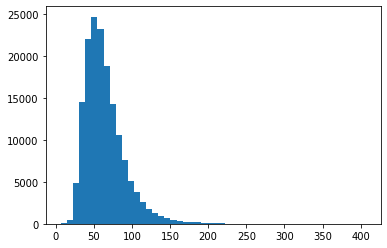

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

word_lengths = list(caption.comment.str.len().astype('Int64'))

plt.hist(word_lengths, bins=50)
plt.show()

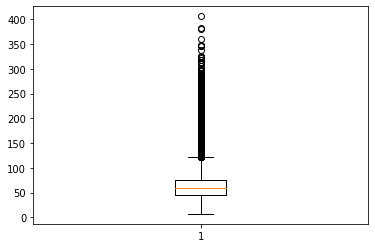

In [13]:
plt.boxplot(word_lengths)
plt.show()

In [14]:
caption['total_length'] = word_lengths

In [15]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [16]:
def tokenize_with_tag(text):
  text = word_tokenize(text)
  text.insert(0,'<START>')
  text.append('<END>')
  return text

In [17]:
caption['tokenize'] = caption['comment'].apply(tokenize_with_tag)

In [18]:
caption['word_count'] = caption['tokenize'].str.len()

In [19]:
caption.head()

,image_name,comment_number,comment,total_length,tokenize,word_count
0,1000092795.jpg,0,two young guys with shaggy hair look at their ...,83,"[<START>, two, young, guys, with, shaggy, hair...",19
1,1000092795.jpg,1,"two young , white males are outside near many ...",54,"[<START>, two, young, ,, white, males, are, ou...",13
2,1000092795.jpg,2,two men in green shirts are standing in a yard .,48,"[<START>, two, men, in, green, shirts, are, st...",13
3,1000092795.jpg,3,a man in a blue shirt standing in a garden .,44,"[<START>, a, man, in, a, blue, shirt, standing...",13
4,1000092795.jpg,4,two friends enjoy time spent together .,39,"[<START>, two, friends, enjoy, time, spent, to...",9


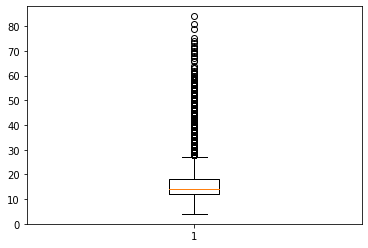

In [20]:
plt.boxplot(caption['word_count'])
plt.show()

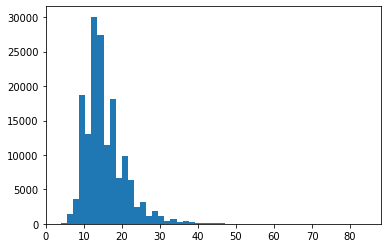

In [21]:
plt.hist(caption['word_count'], bins=50)
plt.show()

In [22]:
caption[caption['word_count']>32].groupby('image_name')['comment_number'].count().sort_values(ascending=False)

image_name
7972860508.jpg    4
7438195398.jpg    4
1150429218.jpg    3
1680674943.jpg    3
3370055006.jpg    3
                 ..
3539960792.jpg    1
3539422395.jpg    1
3538719941.jpg    1
3530843182.jpg    1
991459823.jpg     1
Name: comment_number, Length: 1908, dtype: int64

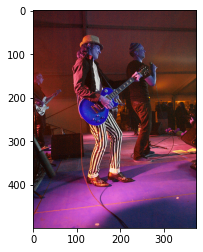

In [23]:
import cv2
img = cv2.imread('/content/flickr-image-dataset/flickr30k_images/flickr30k_images/7438195398.jpg')
plt.imshow(img)

In [24]:
caption[caption['image_name']=='7438195398.jpg']['comment']

151145    three musicians on a stage , two are guitarist...
151146    a man wearing striped pants and a black and wh...
151147    a man in a black jacket and checkered hat wear...
151148    a rock band playing on stage with the lead gui...
151149    at a rock concert a man dressed in black and w...
Name: comment, dtype: object

In [25]:
max_length = 32
df = caption[caption['word_count']<=max_length]

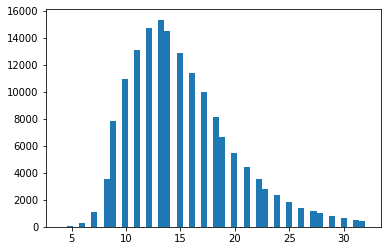

In [26]:
plt.hist(df['word_count'], bins=50)
plt.show()

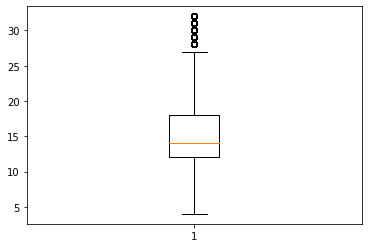

In [27]:
plt.boxplot(df['word_count'])
plt.show()

In [28]:
df.head()

,image_name,comment_number,comment,total_length,tokenize,word_count
0,1000092795.jpg,0,two young guys with shaggy hair look at their ...,83,"[<START>, two, young, guys, with, shaggy, hair...",19
1,1000092795.jpg,1,"two young , white males are outside near many ...",54,"[<START>, two, young, ,, white, males, are, ou...",13
2,1000092795.jpg,2,two men in green shirts are standing in a yard .,48,"[<START>, two, men, in, green, shirts, are, st...",13
3,1000092795.jpg,3,a man in a blue shirt standing in a garden .,44,"[<START>, a, man, in, a, blue, shirt, standing...",13
4,1000092795.jpg,4,two friends enjoy time spent together .,39,"[<START>, two, friends, enjoy, time, spent, to...",9


In [29]:
caption.shape, df.shape

((158914, 6), (156873, 6))

In [30]:
sentences = []

for each in df['tokenize']:
  sentences.append(each)
                   
sentences[0]

['<START>',
 'two',
 'young',
 'guys',
 'with',
 'shaggy',
 'hair',
 'look',
 'at',
 'their',
 'hands',
 'while',
 'hanging',
 'out',
 'in',
 'the',
 'yard',
 '.',
 '<END>']

In [31]:
vocab_column = df['tokenize']
vocab_dict = {}

for each in vocab_column:
  for i in each:
    if i in vocab_dict:
      vocab_dict[i] += 1
    else:
      vocab_dict[i] = 1

In [32]:
import gensim

w2v_model = gensim.models.Word2Vec(sentences=sentences,size=300,window=10,min_count=1)
w2v_model.train(sentences,epochs=10,total_examples=len(sentences))

(13257263, 23756470)

In [33]:
print(f"Total number of words are {len(w2v_model.wv.vocab)}")

Total number of words are 18081


In [34]:
w2v_model.wv.most_similar('woman')

[('lady', 0.8172276020050049),
 ('girl', 0.6683333516120911),
 ('floral', 0.5446783304214478),
 ('person', 0.5008817911148071),
 ('female', 0.49803847074508667),
 ('purse', 0.4973819851875305),
 ('women', 0.4849977493286133),
 ('flower', 0.46693742275238037),
 ('man', 0.45553261041641235),
 ('bride', 0.450062096118927)]

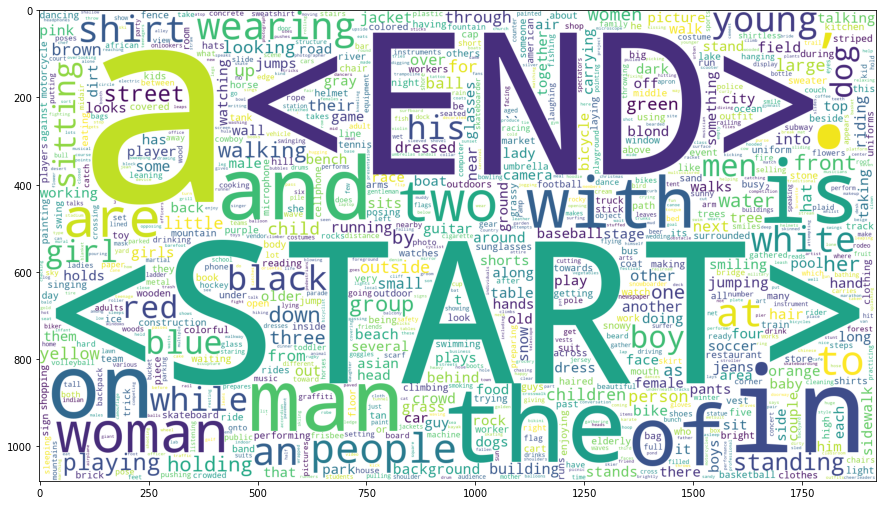

In [35]:
from wordcloud import WordCloud
plt.figure(figsize=(15,20))
wc = WordCloud(background_color="white",width=1920, height=1080, max_words=1000).generate_from_frequencies(vocab_dict)
plt.imshow(wc)
plt.show()

In [36]:
vocab = list(vocab_dict.keys())
vocab_length = len(vocab)

In [37]:
# create embedding matrix

embed_dim = 300
embed_matrix=np.zeros(shape=(vocab_length,embed_dim))
for i,word in enumerate(vocab):
  if word == '<END>':
    embed_matrix[i]=np.zeros(embed_dim)
  else:
    embed_vector=vocab_dict.get(word)
    embed_matrix[i]=embed_vector

In [38]:
np.shape(embed_matrix)

(18081, 300)

In [39]:
vocab_length

18081

In [40]:
word_to_id = {}
id_to_word = {}

for i,each in enumerate(vocab):
  word_to_id[each] = i
  id_to_word[i] = each

In [41]:
df.head()

,image_name,comment_number,comment,total_length,tokenize,word_count
0,1000092795.jpg,0,two young guys with shaggy hair look at their ...,83,"[<START>, two, young, guys, with, shaggy, hair...",19
1,1000092795.jpg,1,"two young , white males are outside near many ...",54,"[<START>, two, young, ,, white, males, are, ou...",13
2,1000092795.jpg,2,two men in green shirts are standing in a yard .,48,"[<START>, two, men, in, green, shirts, are, st...",13
3,1000092795.jpg,3,a man in a blue shirt standing in a garden .,44,"[<START>, a, man, in, a, blue, shirt, standing...",13
4,1000092795.jpg,4,two friends enjoy time spent together .,39,"[<START>, two, friends, enjoy, time, spent, to...",9


In [42]:
df.tail()

,image_name,comment_number,comment,total_length,tokenize,word_count
158910,998845445.jpg,0,a man in shorts and a hawaiian shirt leans ove...,117,"[<START>, a, man, in, shorts, and, a, hawaiian...",27
158911,998845445.jpg,1,"a young man hanging over the side of a boat , ...",105,"[<START>, a, young, man, hanging, over, the, s...",27
158912,998845445.jpg,2,a man is leaning off of the side of a blue and...,89,"[<START>, a, man, is, leaning, off, of, the, s...",25
158913,998845445.jpg,3,"a man riding a small boat in a harbor , with f...",82,"[<START>, a, man, riding, a, small, boat, in, ...",20
158914,998845445.jpg,4,a man on a moored blue and white boat with hil...,77,"[<START>, a, man, on, a, moored, blue, and, wh...",19


In [43]:
one_hot_sentences = []
max_length = 0

for each in sentences:
  temp = []
  for i in each:
    temp.append(word_to_id[i])

  if len(temp)>max_length:
    max_length = len(temp)

  one_hot_sentences.append(temp)

print(f"max length: {max_length}")
one_hot_sentences[:5]

max length: 32


[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 [0, 1, 2, 19, 20, 21, 22, 23, 24, 25, 26, 17, 18],
 [0, 1, 27, 14, 28, 29, 22, 30, 14, 31, 16, 17, 18],
 [0, 31, 32, 14, 31, 33, 34, 30, 14, 31, 35, 17, 18],
 [0, 1, 36, 37, 38, 39, 40, 17, 18]]

In [44]:
import tensorflow
tensorflow.config.run_functions_eagerly(True)
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [45]:
padded_one_hot = pad_sequences(one_hot_sentences, maxlen=max_length, padding='post')

In [46]:
np.shape(padded_one_hot)

(156873, 32)

In [47]:
df.shape

(156873, 6)

In [48]:
decoder_answers = []

for each in padded_one_hot:
  decoder_answers.append(each[1:])

decoder_answers = pad_sequences(decoder_answers, maxlen=max_length, padding='post')

In [49]:
df['padded_one_hot'] = list(padded_one_hot)
df['decoder_answers'] = list(decoder_answers)

<ipython-input-49-85f997ac2ffb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['padded_one_hot'] = list(padded_one_hot)
<ipython-input-49-85f997ac2ffb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['decoder_answers'] = list(decoder_answers)


In [50]:
df.head()

,image_name,comment_number,comment,total_length,tokenize,word_count,padded_one_hot,decoder_answers
0,1000092795.jpg,0,two young guys with shaggy hair look at their ...,83,"[<START>, two, young, guys, with, shaggy, hair...",19,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,1000092795.jpg,1,"two young , white males are outside near many ...",54,"[<START>, two, young, ,, white, males, are, ou...",13,"[0, 1, 2, 19, 20, 21, 22, 23, 24, 25, 26, 17, ...","[1, 2, 19, 20, 21, 22, 23, 24, 25, 26, 17, 18,..."
2,1000092795.jpg,2,two men in green shirts are standing in a yard .,48,"[<START>, two, men, in, green, shirts, are, st...",13,"[0, 1, 27, 14, 28, 29, 22, 30, 14, 31, 16, 17,...","[1, 27, 14, 28, 29, 22, 30, 14, 31, 16, 17, 18..."
3,1000092795.jpg,3,a man in a blue shirt standing in a garden .,44,"[<START>, a, man, in, a, blue, shirt, standing...",13,"[0, 31, 32, 14, 31, 33, 34, 30, 14, 31, 35, 17...","[31, 32, 14, 31, 33, 34, 30, 14, 31, 35, 17, 1..."
4,1000092795.jpg,4,two friends enjoy time spent together .,39,"[<START>, two, friends, enjoy, time, spent, to...",9,"[0, 1, 36, 37, 38, 39, 40, 17, 18, 0, 0, 0, 0,...","[1, 36, 37, 38, 39, 40, 17, 18, 0, 0, 0, 0, 0,..."


In [51]:
final = df[['image_name','comment','padded_one_hot','decoder_answers']]
final.head()

,image_name,comment,padded_one_hot,decoder_answers
0,1000092795.jpg,two young guys with shaggy hair look at their ...,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,1000092795.jpg,"two young , white males are outside near many ...","[0, 1, 2, 19, 20, 21, 22, 23, 24, 25, 26, 17, ...","[1, 2, 19, 20, 21, 22, 23, 24, 25, 26, 17, 18,..."
2,1000092795.jpg,two men in green shirts are standing in a yard .,"[0, 1, 27, 14, 28, 29, 22, 30, 14, 31, 16, 17,...","[1, 27, 14, 28, 29, 22, 30, 14, 31, 16, 17, 18..."
3,1000092795.jpg,a man in a blue shirt standing in a garden .,"[0, 31, 32, 14, 31, 33, 34, 30, 14, 31, 35, 17...","[31, 32, 14, 31, 33, 34, 30, 14, 31, 35, 17, 1..."
4,1000092795.jpg,two friends enjoy time spent together .,"[0, 1, 36, 37, 38, 39, 40, 17, 18, 0, 0, 0, 0,...","[1, 36, 37, 38, 39, 40, 17, 18, 0, 0, 0, 0, 0,..."


### Image Processing

In [52]:
import cv2
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [53]:
final.shape

(156873, 4)

In [54]:
np.shape([i for i in final.padded_one_hot])

(156873, 32)

In [55]:
# batch_images, batch_captions = next(generator)
# print(np.shape(batch_images), np.shape(batch_captions))

# # Plot the first few images in the batch
# for i in range(0,32,5):
#     plt.imshow(batch_images[i].astype('uint8'))
#     cc = batch_captions[i]
#     change = []
#     for i in cc:
#       if i not in [0,18]:
#         change.append(id_to_word[i])
#     title = ' '.join(change[1:-1])
#     plt.title(title)
#     plt.show()

### Modelling

In [56]:
import tensorflow

In [57]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Embedding, LSTM, Dropout, Reshape, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

In [58]:
image_input = Input(shape=(224, 224, 3))

image_branch = VGG16(weights='imagenet', include_top=False, input_tensor=image_input)
# image_branch = GlobalAveragePooling2D()(image_branch.output)
flatten = Flatten()(image_branch.output)

hidden_state = Dense(64, activation='tanh')(flatten)
cell_state = Dense(64, activation='tanh')(flatten)

text_input = Input(shape=(max_length,))
embed = Embedding(input_dim=vocab_length, output_dim=300, weights=[embed_matrix], trainable=False)
text_embed = embed(text_input)

lstm = LSTM(64, return_sequences=True, return_state=True)
text_output, _, _ = lstm(text_embed, initial_state = [hidden_state, cell_state])

dense = Dense(vocab_length, activation='softmax')
output = dense(text_output)

model = Model([image_input, text_input], output)
model.compile(loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(),metrics=['acc'],optimizer='adam')

58889256/58889256 [==============================] - 0s 0us/step


In [59]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [60]:
!mkdir saved
!mkdir saved/weights

In [61]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the file path for saving the model weights
checkpoint_filepath = 'saved/weights/model.{epoch:02d}-{val_accuracy:.2f}.h5'

# Create a ModelCheckpoint callback that saves the best model weights based on validation accuracy
checkpoint_callback = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='max'
)

# Create an EarlyStopping callback that stops training when validation accuracy reaches 0.95
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=1,
    mode='max',
    baseline=0.95
)

In [62]:
data_dir = "/content/flickr-image-dataset/flickr30k_images/flickr30k_images" 
batch_size = 128

filepaths = [os.path.join(data_dir, fname) for fname in final['image_name']]
captions = [each for each in final.padded_one_hot]
answers = [each for each in final.decoder_answers]

def image_generator(data_dir, batch_size):
    # Loop over the file paths and load the images in batches
    while True:
        for i in range(0, len(filepaths), batch_size):
            batch_filepaths = filepaths[i:i+batch_size]
            batch_captions = captions[i:i+batch_size]
            batch_answers = answers[i:i+batch_size]
            batch_images = []
            for j, filepath in enumerate(batch_filepaths):
                # Load the image and convert it to a NumPy array
                img = load_img(filepath, target_size=(224, 224))
                img_array = img_to_array(img)
                batch_images.append(img_array)
            yield (np.array(batch_images), np.array(batch_captions)), np.array(batch_answers)

In [63]:
epochs = 10
num_batches = len(filepaths)//batch_size

In [64]:
generator = image_generator(data_dir, batch_size)

In [66]:
history = model.fit(generator,steps_per_epoch=num_batches,epochs=epochs,callbacks=[checkpoint_callback, early_stopping_callback])